Reading CSV...
Amount of data items:8036
Reading output values and images...
Training NN...
Train on 192 samples, validate on 48 samples
Epoch 1/5
192/192 [==============================] - 6s - loss: 2.6646 - val_loss: 1.5027
Epoch 2/5
192/192 [==============================] - 6s - loss: 0.5863 - val_loss: 0.0737
Epoch 3/5
192/192 [==============================] - 6s - loss: 0.1016 - val_loss: 0.1231
Epoch 4/5
192/192 [==============================] - 6s - loss: 0.0787 - val_loss: 0.0661
Epoch 5/5
192/192 [==============================] - 6s - loss: 0.0493 - val_loss: 0.0427


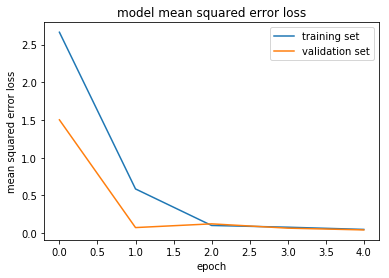

Trained model saved...


In [13]:
# modules import section
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D

# import data
# data buffers
input_images = []
lines = []
output_values = []
base_path = './data/'
data_file_csv = open(base_path + 'driving_log.csv')
data_reader = csv.reader(data_file_csv)
first_line = True
# read csv file
print('Reading CSV...')
for line in data_reader:
    if first_line:
        first_line = False
    else:
        lines.append(line)
                     
print('Amount of data items:' + str(len(lines)))

# read images and output values
print('Reading output values and images...')

steering_correction = 0.2
skip_images = 0
for line in lines:
    skip_images+= 1
    if skip_images == 10:
        skip_images = 0
        for i in range(3):
            image_file_name = line[i]
            image_full_filename = image_file_name.split('/')[-1]
            image_path = base_path + 'IMG/' + image_full_filename
            image = cv2.imread(image_path)
            input_images.append(image)
        output_value_steering = float(line[3])
        output_value_steering_left = output_value_steering + steering_correction
        output_value_steering_right = output_value_steering - steering_correction
        output_values.append(output_value_steering)
        output_values.append(output_value_steering_left)
        output_values.append(output_value_steering_right)

aug_input_images = []
aug_output_values = []
for input_image, output_value in zip(input_images, output_values):
    aug_input_images.append(input_image)
    aug_output_values.append(output_value)
    aug_input_images.append(cv2.flip(input_image, 1))
    aug_output_values.append(-1.0 * output_value)

# convert to np arrays
X_train_data = np.array(aug_input_images)
y_train_data = np.array(aug_output_values)
    
#create a nn with keras
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Conv2D(6,(5,5),activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(6,(5,5),activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

print('Training NN...')
model.compile(loss='mse', optimizer='adam')
fit_history =  model.fit(X_train_data, y_train_data, validation_split=0.2, 
                         shuffle=True, epochs=5, verbose=1)
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')
print('Trained model saved...')
